In [4]:
import os
import gc
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tifffile as tiff
import cv2 as cv
import albumentations as albu

from tqdm.notebook import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.utils.data as D
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import segmentation_models_pytorch as smp

from albumentations import (
    Compose, OneOf, Normalize, HorizontalFlip, VerticalFlip, RandomRotate90, Transpose, ShiftScaleRotate, IAAAdditiveGaussianNoise, IAAPerspective,
    CLAHE, RandomBrightness, RandomGamma, IAASharpen, Blur, MotionBlur, RandomContrast, HueSaturationValue, VerticalFlip,
    RandomRotate90, OneOf, Resize, Rotate, RandomBrightnessContrast, Lambda
    )
from albumentations.pytorch import ToTensorV2, ToTensor
        
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
def visualize_numpy(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
def visualize_tensor(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image[0])
    plt.show()

In [6]:
TRAIN_DATA_DIR = '/home/arti/DL/HuBMAP/Data/256x256/'
TEST_DATA_DIR = '/home/arti/DL/HuBMAP/Data/'
MODEL_SAVE_DIR = "/home/arti/DL/HuBMAP/OUTPUTS/models/"
TILE_SIZE = 256
REDUCE_RATE = 4
SEED = 42
BATCH_SIZE = 16
NUM_EPOCHS = 20

torch.cuda.empty_cache()


random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [7]:
train_img_paths, train_mask_paths = [], []
for dt in ['train/', 'masks/']:
    for item in os.listdir(TRAIN_DATA_DIR+dt):
        if dt=='train/':
            train_img_paths.append(TRAIN_DATA_DIR+'train/'+item)
        elif dt=='masks/':
            train_mask_paths.append(TRAIN_DATA_DIR+'masks/'+item)  
            
paths = list(zip(train_img_paths, train_mask_paths))
len(paths)

3676

In [8]:
paths[:1]

[('/home/arti/DL/HuBMAP/Data/256x256/train/095bf7a1f_628.png',
  '/home/arti/DL/HuBMAP/Data/256x256/masks/095bf7a1f_628.png')]

In [9]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, paths, transform=None):
        self.paths = paths
        self.transform = transform
        
    def __len__(self):
        return len(self.paths)

    def __getitem__(self, i):
        image = cv.imread(self.paths[i][0])
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        mask = cv.imread(self.paths[i][1], 0)  # 0=cv2.IMREAD_GRAYSCALE, np.array of 0 and 1. (256,256)
        if self.transform:
            augmented = self.transform(image=image, mask=mask) # image np(256,256,3) -> tensor(3,256,256)
            image, mask = augmented['image'], augmented['mask']
            mask = mask.unsqueeze(0) # (256,256) -> (1, 256, 256)
        return image, mask
    
class TestDataset(Dataset):
    def __init__(self, paths, transform=None):
        self.paths = paths
        self.transform = transform
        
    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        image = cv.imread(self.paths[i][0])
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image

In [10]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):
    
    if data == 'train':
        return Compose([
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            RandomRotate90(p=0.5),
            Transpose(p=0.5),

            ShiftScaleRotate(scale_limit=0.2, rotate_limit=0, shift_limit=0.2, p=0.2, border_mode=0),

            IAAAdditiveGaussianNoise(p=0.2),
            IAAPerspective(p=0.5),

            OneOf([
                    CLAHE(p=1),
                    RandomBrightness(p=1),
                    RandomGamma(p=1),
                ], p=0.9,
            ),

            OneOf([
                IAASharpen(p=1),
                Blur(blur_limit=3, p=1),
                MotionBlur(blur_limit=3, p=1),
            ], p=0.9,
            ),

            OneOf([   
                RandomContrast(p=1),
                HueSaturationValue(p=1),],  p=0.9,
            ),
            Compose([
                VerticalFlip(p=0.5),              
                RandomRotate90(p=0.5)]
            ),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),  #ToTensor(num_classes=2),
        ])    
    elif data == 'valid':
        return Compose([
            Resize(256,256),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

In [11]:
train_paths, val_paths = train_test_split(paths, test_size=0.2, random_state=SEED, shuffle=True)

print("Amount of train samples:", len(train_paths))
print("Amount of val samples:", len(val_paths))

Amount of train samples: 2940
Amount of val samples: 736


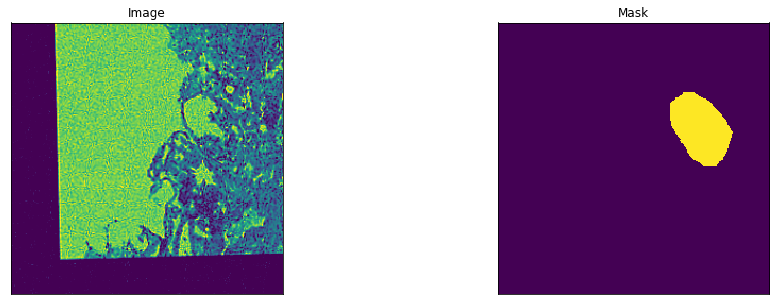

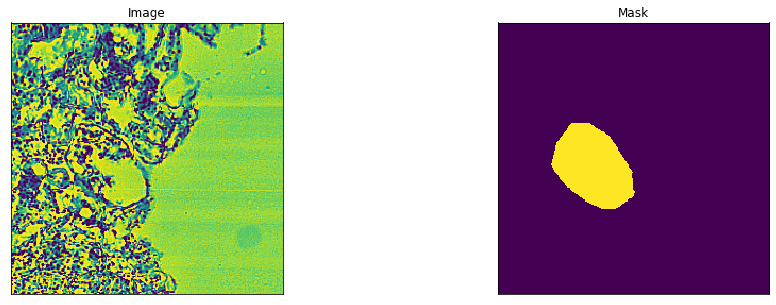

In [14]:
augmented_dataset = TrainDataset(train_paths,
                                  transform=get_transforms(data='train'),)
        
for i in range(2):
    image, mask = augmented_dataset[1]
    visualize_tensor(image=image, mask=mask)

In [24]:
model = smp.Unet(encoder_name='se_resnext50_32x4d', encoder_weights='imagenet', activation='sigmoid')
#model = smp.FPN(encoder,encoder_weights=encoder_weights)

loss = smp.utils.losses.DiceLoss()  # нужно взвешенный CCE - ln(DICE)
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, amsgrad=False)

In [26]:
train_dataset = TrainDataset(train_paths, transform=get_transforms(data='train'),)
valid_dataset = TrainDataset(val_paths, transform=get_transforms(data='valid'),)

train_loader = D.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
valid_loader = D.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

In [27]:
next(model.parameters()).device

device(type='cpu')

In [28]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

In [29]:
next(model.parameters()).device

device(type='cuda', index=0)

In [32]:
best_loss = 1.0

train_losses, val_losses = [], []
train_scores, val_scores = [], []

In [34]:
optimizer.param_groups[0]['lr'] = 1e-5

In [36]:
for i in range(0, 10):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    train_losses.append(train_logs['dice_loss'])
    val_losses.append(valid_logs['dice_loss'])
    train_scores.append(train_logs['iou_score'])
    val_scores.append(valid_logs['iou_score'])
    
    print()
    
    if best_loss > valid_logs['dice_loss']:
        best_loss = valid_logs['dice_loss']
        torch.save(model, os.path.join(MODEL_SAVE_DIR, 'best_model_sub.pth'))
        print('Model saved!')


Epoch: 0
valid: 100%|██████████| 46/46 [00:04<00:00, 10.58it/s, dice_loss - 0.132, iou_score - 0.7787] 


Epoch: 1
valid: 100%|██████████| 46/46 [00:04<00:00, 10.53it/s, dice_loss - 0.1413, iou_score - 0.7651]


Epoch: 2
valid: 100%|██████████| 46/46 [00:04<00:00, 10.51it/s, dice_loss - 0.1312, iou_score - 0.7797]


Epoch: 3
valid: 100%|██████████| 46/46 [00:04<00:00, 10.55it/s, dice_loss - 0.1271, iou_score - 0.786] 


Epoch: 4
valid: 100%|██████████| 46/46 [00:04<00:00, 10.59it/s, dice_loss - 0.1275, iou_score - 0.7848]


Epoch: 5
valid: 100%|██████████| 46/46 [00:04<00:00, 10.53it/s, dice_loss - 0.127, iou_score - 0.785]  


Epoch: 6
valid: 100%|██████████| 46/46 [00:04<00:00, 10.57it/s, dice_loss - 0.1235, iou_score - 0.7904]

Model saved!

Epoch: 7
valid: 100%|██████████| 46/46 [00:04<00:00, 10.54it/s, dice_loss - 0.1207, iou_score - 0.7949]

Model saved!

Epoch: 8
valid: 100%|██████████| 46/46 [00:04<00:00, 10.54it/s, dice_loss - 0.1215, iou_score - 0.7932]


Epoch: 9
valid: 100

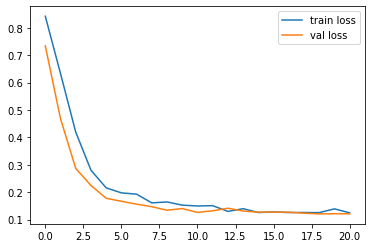

In [37]:
plt.figure()
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.legend()
plt.show();

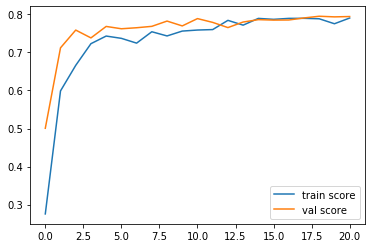

In [38]:
plt.figure()
plt.plot(train_scores, label='train score')
plt.plot(val_scores, label='val score')
plt.legend()
plt.show();

# Submission

In [45]:
import os
import gc
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tifffile as tiff
import cv2 as cv
import albumentations as albu

from tqdm.notebook import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split

import pathlib, sys, os, random, time
import numba, gc, cv2

from tqdm.notebook import tqdm
import rasterio
from rasterio.windows import Window

import torch
import torch.nn as nn
import torch.utils.data as D
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import segmentation_models_pytorch as smp

from albumentations import (
    Compose, OneOf, Normalize, HorizontalFlip, VerticalFlip, RandomRotate90, Transpose, ShiftScaleRotate, IAAAdditiveGaussianNoise, IAAPerspective,
    CLAHE, RandomBrightness, RandomGamma, IAASharpen, Blur, MotionBlur, RandomContrast, HueSaturationValue, VerticalFlip,
    RandomRotate90, OneOf, Resize, Rotate, RandomBrightnessContrast, Lambda
    )
from albumentations.pytorch import ToTensorV2, ToTensor

from albumentations import *
        
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print(device)

cuda:0


In [46]:
def make_grid(shape, window=256, min_overlap=32):
    """
        Return Array of size (N,4), where N - number of tiles,
        2nd axis represente slices: x1,x2,y1,y2 
    """
    x, y = shape
    nx = x // (window - min_overlap) + 1
    x1 = np.linspace(0, x, num=nx, endpoint=False, dtype=np.int64)
    x1[-1] = x - window
    x2 = (x1 + window).clip(0, x)
    ny = y // (window - min_overlap) + 1
    y1 = np.linspace(0, y, num=ny, endpoint=False, dtype=np.int64)
    y1[-1] = y - window
    y2 = (y1 + window).clip(0, y)
    slices = np.zeros((nx,ny, 4), dtype=np.int64)
    
    for i in range(nx):
        for j in range(ny):
            slices[i,j] = x1[i], x2[i], y1[j], y2[j]    
    return slices.reshape(nx*ny,4)

@numba.njit()
def rle_numba(pixels):
    size = len(pixels)
    points = []
    if pixels[0] == 1: points.append(0)
    flag = True
    for i in range(1, size):
        if pixels[i] != pixels[i-1]:
            if flag:
                points.append(i+1)
                flag = False
            else:
                points.append(i+1 - points[-1])
                flag = True
    if pixels[-1] == 1: points.append(size-points[-1]+1)    
    return points

def rle_numba_encode(image):
    pixels = image.flatten(order = 'F')
    points = rle_numba(pixels)
    return ' '.join(str(x) for x in points)

In [47]:
TEST_DATA_DIR = '/home/arti/DL/HuBMAP/Data/'
MODEL_SAVE_DIR = "/home/arti/DL/HuBMAP/OUTPUTS/models/"
TILE_SIZE = 256
REDUCE_RATE = 4
SEED = 42
BATCH_SIZE = 16
NUM_EPOCHS = 20

WINDOW=1024
MIN_OVERLAP=32
NEW_SIZE=256

torch.cuda.empty_cache()

In [48]:
model = smp.Unet(encoder_name='se_resnext50_32x4d', 
                 encoder_weights='imagenet', 
                 activation='sigmoid')

model = torch.load(os.path.join(MODEL_SAVE_DIR, 'best_model_sub.pth'), map_location=torch.device(device))
model.to(device);
model.eval();

In [49]:
# ====================================================
# ValTransforms
# ====================================================
def ValTransforms():
    return Compose([
        Resize(256,256),
        Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
            #ToTensorV2(),
    ])

In [50]:
identity_trfm = Lambda(image = lambda x,cols=None,rows=None : x)
identity = rasterio.Affine(1, 0, 0, 0, 1, 0)

transforms = ValTransforms()

/home/arti/anaconda3/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:2964: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  "Using lambda is incompatible with multiprocessing. "


In [51]:
p = pathlib.Path('/home/arti/DL/HuBMAP/Data/')
subm = {}

for i, filename in tqdm(enumerate(p.glob('test/*.tiff')), 
                        total = len(list(p.glob('test/*.tiff')))):
    
    print(f'{i+1} Predicting {filename.stem}')
    
    dataset = rasterio.open(filename.as_posix(), transform = identity)
    slices = make_grid(dataset.shape, window=WINDOW, min_overlap=MIN_OVERLAP)
    preds = np.zeros(dataset.shape, dtype=np.uint8)
    
    for (x1,x2,y1,y2) in slices:
        image = dataset.read([1,2,3],
                    window=Window.from_slices((x1,x2),(y1,y2))) 
        
        # SLICE TO TORCH.TENSOR
        image = np.moveaxis(image, 0, -1)  
        # resize and normalize
        image = transforms(image=image)['image']
        # equivalent ToTensorV2
        image = np.moveaxis(image, -1, 0)
        image = torch.from_numpy(image)
        
        with torch.no_grad():
            # (3,256,256) -> (1,3,256,256)
            image = image.float().to(device)[None]
            
            score = model(image)
            score = score.cpu().numpy()[0][0]   
                    
            # UPscaling 256->1024
            score = cv2.resize(score, (WINDOW, WINDOW)) 
            
            #print(np.mean(score), np.median(score))
            
        
        preds[x1:x2,y1:y2] = (score > 0.5).astype(np.uint8)      
    subm[i] = {'id':filename.stem, 'predicted': rle_numba_encode(preds)}
    del preds
    gc.collect();

1 Predicting afa5e8098


/home/arti/anaconda3/lib/python3.7/site-packages/rasterio/__init__.py:207: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


2 Predicting c68fe75ea


/home/arti/anaconda3/lib/python3.7/site-packages/rasterio/__init__.py:207: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


3 Predicting b9a3865fc
4 Predicting b2dc8411c
5 Predicting 26dc41664



In [53]:
submission = pd.DataFrame.from_dict(subm, orient='index')
submission.to_csv('submission.csv', index=False)
submission

,id,predicted
0,afa5e8098,71578652 254 71615452 254 71652252 254 7168905...
1,c68fe75ea,21283638 37 21310474 43 21337313 46 21364151 5...
2,b9a3865fc,60927620 31 60958912 37 60990206 40 61021498 4...
3,b2dc8411c,56380364 35 56395205 42 56410048 44 56424889 5...
4,26dc41664,245833005 13 245871156 27 245909314 31 2459474...


In [57]:
def rle_decode(mask_rle, shape=(256, 256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')

In [ ]:
def visualize_tensor(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    

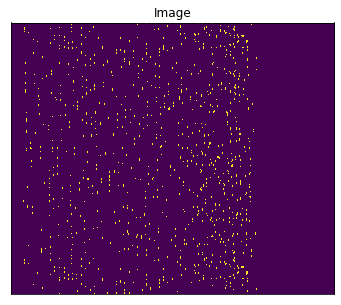

In [61]:
image = rle_decode(submission.loc[2].predicted, shape=(36800, 43780))
visualize_tensor(image=image)